## 1. Setup the game

In [1]:
!pip install gym_super_mario_bros==7.3.0 nes_py

In [2]:
from nes_py.wrappers import JoypadSpace
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
import gym

In [27]:
from nes_py import NESEnv
_reset = NESEnv.reset

def reset(*args, **kwargs):
    obs_info = _reset(*args, **kwargs)
    obs, info = obs_info if type(obs_info) == tuple else (obs_info, {})
    return obs, info

NESEnv.reset = reset

In [35]:
SIMPLE_MOVEMENT

[['NOOP'],
 ['right'],
 ['right', 'A'],
 ['right', 'B'],
 ['right', 'A', 'B'],
 ['A'],
 ['left']]

In [36]:
# Setup game
env = gym.make('SuperMarioBros2-v0', apply_api_compatibility=True, render_mode='human')
# env.metadata['render.modes'] = ['human', 'rgb_array'] 
env = JoypadSpace(env, SIMPLE_MOVEMENT)

/Users/nanda_raj/opt/anaconda3/lib/python3.9/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment SuperMarioBros2-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/Users/nanda_raj/opt/anaconda3/lib/python3.9/site-packages/gym/envs/registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(


In [37]:
SIMPLE_MOVEMENT[env.action_space.sample()]

['left']

In [38]:
# Create a flag - restart or not
done = True
for step in range(10000):
    if done:
        env.reset()
    action = env.action_space.sample()
    state, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    
    env.render()
env.close()

/Users/nanda_raj/opt/anaconda3/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:137: UserWarning: WARN: The obs returned by the `reset()` method was expecting a numpy array, actual type: <class 'tuple'>
  logger.warn(
/Users/nanda_raj/opt/anaconda3/lib/python3.9/site-packages/gym/spaces/box.py:227: UserWarning: WARN: Casting input x to numpy array.
  logger.warn("Casting input x to numpy array.")
/Users/nanda_raj/opt/anaconda3/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:165: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/Users/nanda_raj/opt/anaconda3/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/Users/nanda_raj/opt/anaconda3/lib/python3.9/site-packages/gym/utils/passive_env_checker.py

## 2. Pre-processing


In [39]:
import numpy as np

In [40]:
!pip3 install torch torchvision torchaudio

In [41]:
!pip install 'stable-baselines3[extra]' #to use RL Algorithms

In [42]:
#Import Frame Stacker Wrapper(capture couple of frames) and Gray-scaling wrapper(coloured game to grayscale version, to cut down processing time)
from gym.wrappers import FrameStack, GrayScaleObservation

#Import Vectorization Wrappers
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv

#Import matplotlib
from matplotlib import pyplot as plt


In [43]:
# 1. Create the base environment
env = gym_super_mario_bros.make('SuperMarioBros-v0')
# 2. Simplify the controls 
env = JoypadSpace(env, SIMPLE_MOVEMENT)
# 3. Grayscale
env = GrayScaleObservation(env, keep_dim=True)
# 4. Wrap inside the Dummy Environment
env = DummyVecEnv([lambda: env])
# 5. Stack the frames
env = VecFrameStack(env, 4, channels_order='last')

In [48]:
state=env.reset()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [49]:
type(state)

numpy.ndarray

In [50]:
state.shape

(240, 256, 3)

In [51]:
state, reward, terminated, truncated, info= env.step([env.action_space.sample()])

/Users/nanda_raj/opt/anaconda3/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(


ValueError: not enough values to unpack (expected 5, got 4)

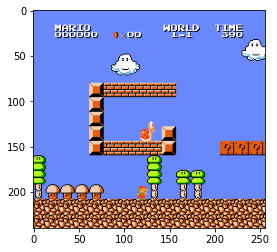

In [52]:
plt.imshow(state)

## 3. Model Training

In [53]:
# Import os for file path management
import os 
# Import PPO for algos
from stable_baselines3 import PPO
# Import Base Callback for saving models
from stable_baselines3.common.callbacks import BaseCallback

In [54]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [55]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [56]:
# Setup model saving callback
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [57]:
# This is the AI model started
model = PPO('CnnPolicy', env, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001, 
            n_steps=512) 

Using cpu device
Wrapping the env in a VecTransposeImage.


In [58]:
# Train the AI model, this is where the AI model starts to learn
model.learn(total_timesteps=1000000, callback=callback)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [59]:
model.save('thisisatestmodel')

## 4. Testing

In [60]:
# Load model
model = PPO.load('./train/best_model_1000000')

FileNotFoundError: [Errno 2] No such file or directory: 'train/best_model_1000000.zip'

In [61]:
state = env.reset()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [62]:
# Start the game 
state = env.reset()
# Loop through the game
while True: 
    
    action, _ = model.predict(state)
    state, reward, done, info = env.step(action)
    env.render()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.